# BoomBikes Sharing Assignment
## Assignment is divided into following parts:
- Data Understanding - Quality Check - Visualising the Data
- Exploratory Data Analysis - EDA Including Visualising Categorical Variables and Handling
- Dummy Variables Encoding and Converting Data
- Splitting the Data into Training and Testing Sets
- Building our Model powered by sklearn RFE (Recursive Feature Elimination) and Statsmodel API
- Residual Analysis on train data
- Looking for patterns in the residuals
- Making Predictions on test set
- Model Evaluation
- Conclusion

# Submitted by: Shashikumar S S

## Importing Libraries

In [83]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [84]:
# to display all coulmns of a dataframe
pd.set_option('display.max_column', None)

# to display all rows of a dataframe
pd.set_option('display.max_rows', None)

# to display all items of a long sequence
pd.set_option('display.max_seq_items', None)

# to display complete contents inside a cell in dataframe
pd.set_option('display.max_colwidth', None)

pd.set_option('expand_frame_repr', True)

## Reading and Understanding the Data

In [85]:
bike_df = pd.read_csv("download.csv")

In [86]:
# Check the head of the dataset
bike_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## data contains 730 rows and 16 columns

In [87]:
bike_df.shape

(730, 16)

## These columns are not required from model development point of view. Let's drop them.

In [88]:
drop_these_columns = ["instant",
                      "dteday"]
bike_df.drop(drop_these_columns, inplace=True, axis=1)
bike_df.shape

(730, 14)

## Visualising the Data

Let's now spend some time doing what is arguably the most important step - **understanding the data**.
- If there is some obvious multicollinearity going on, this is the first place to catch it
- Here's where we will also identify if some predictors directly have a strong association with the outcome variable

We'll visualise our data using `matplotlib` and `seaborn`.

#### Visualising Numeric Variables

Let's make a pairplot of all the numeric variables

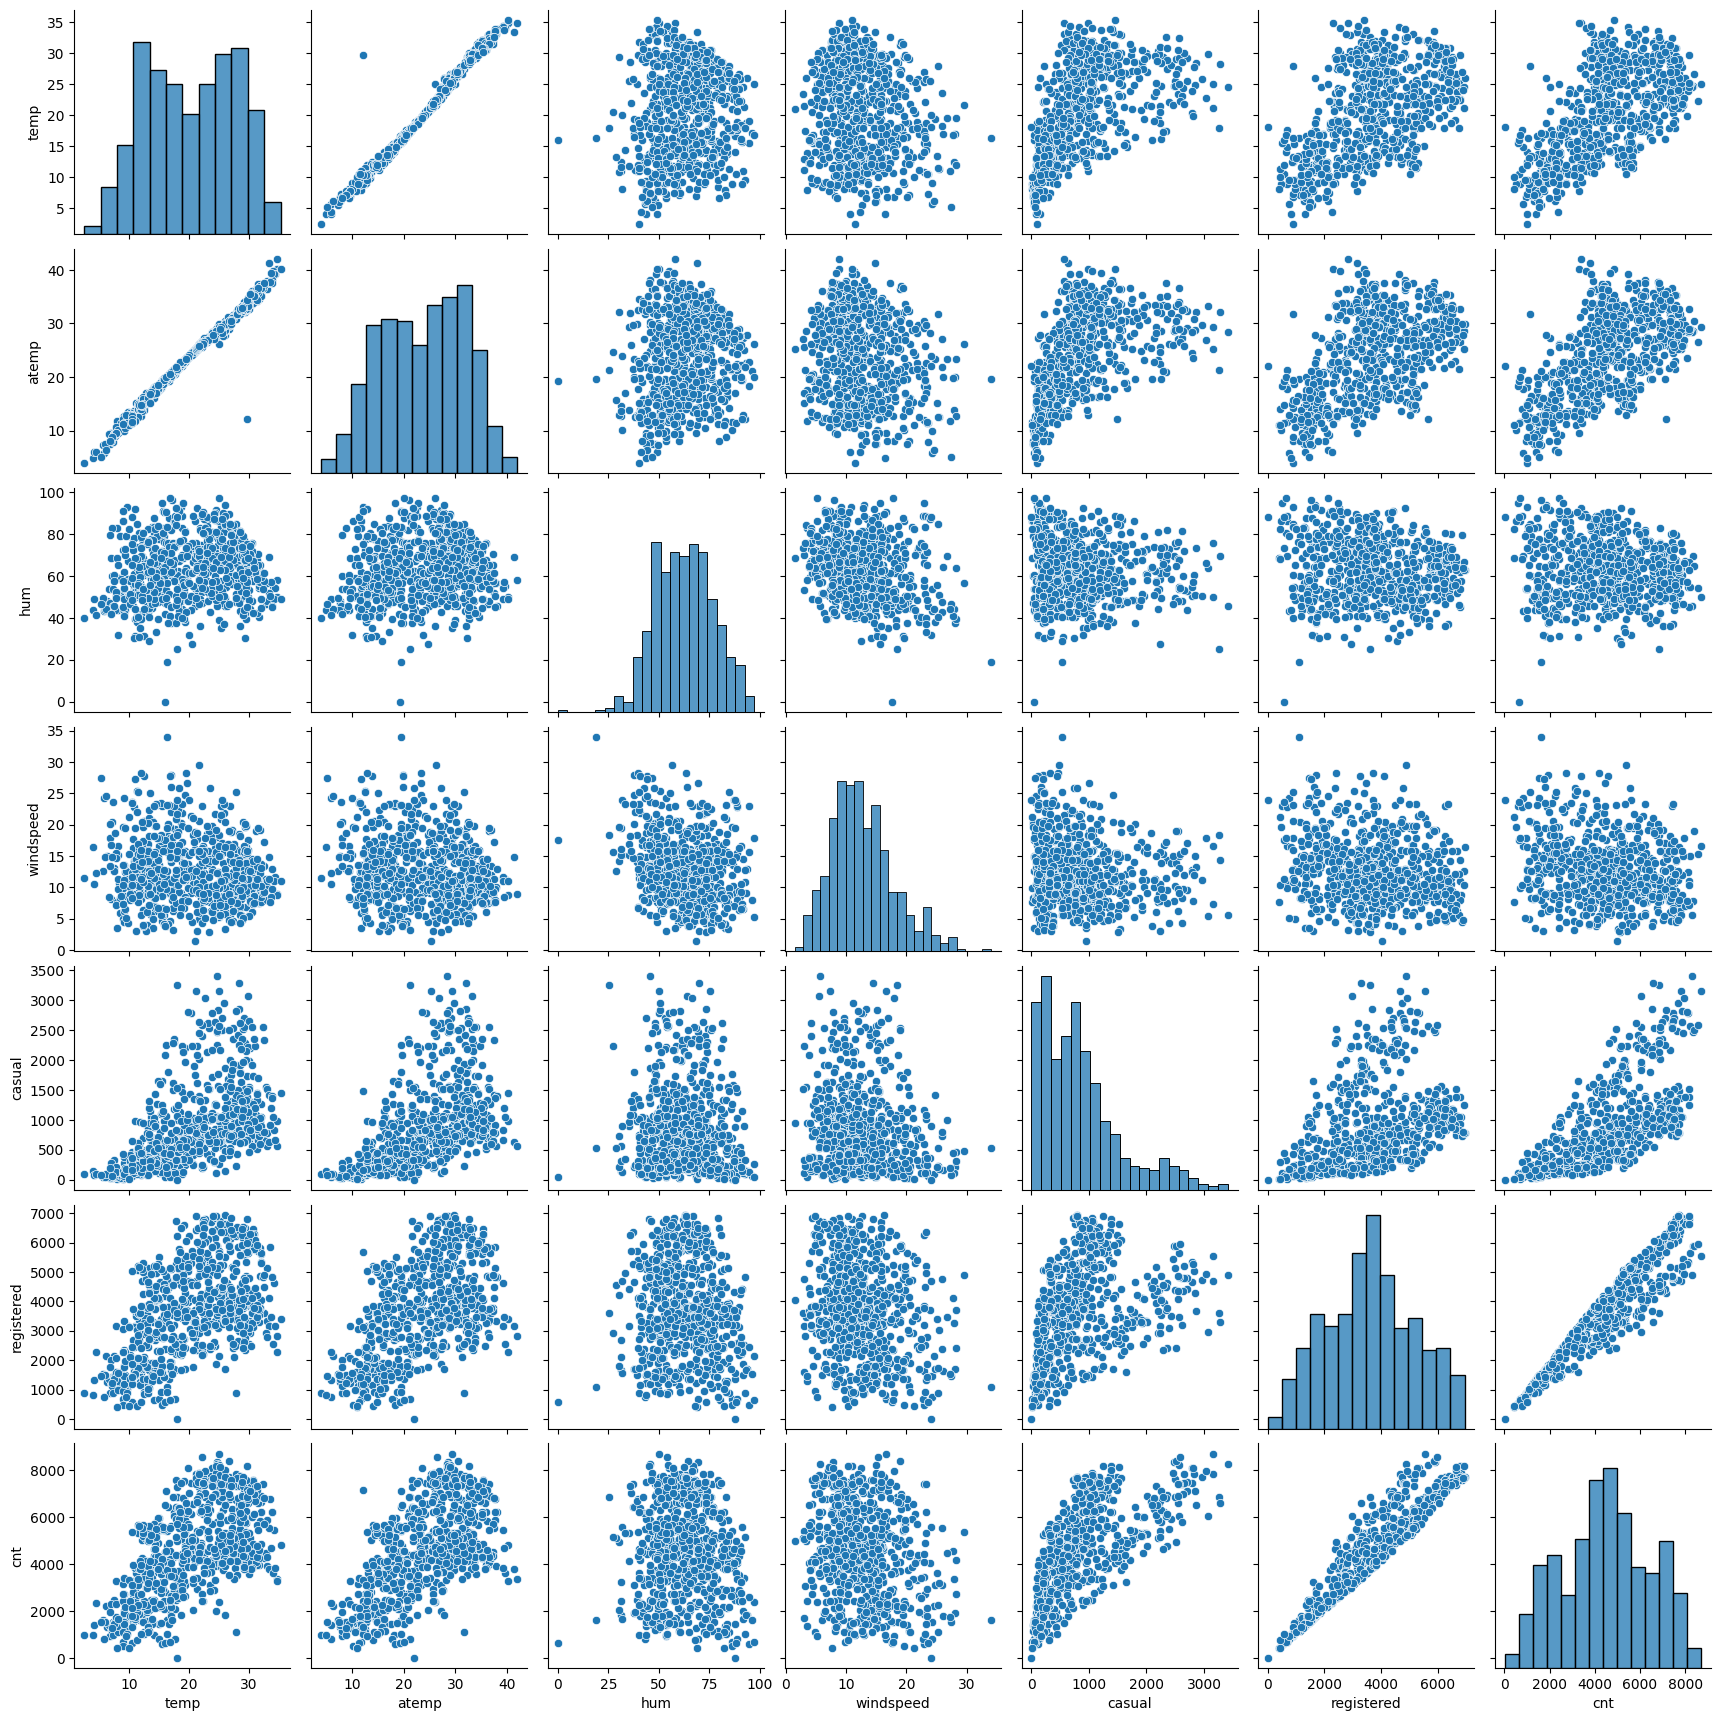

In [89]:
sns.pairplot(bike_df[["temp","atemp","hum","windspeed","casual","registered","cnt"]])
plt.show()

## Few observations from above pairplot:
#### 1. temp and atemp are highly correlated.
#### 2. temp is also correlated with casual, registered and cnt.
#### 3. atemp is also correlated with casual, registered and cnt.
#### 4. casual is correlated with registered and cnt. And thats obvious because casual + registered = cnt

#### We need to take care of these correlations among possible predictor variables to avoid multicollinearity once we start building our Multiple Linear Regression Model.

#### Also we will not use casual and registered in our preprocessed data for model training. This might leak out the crucial information and model might get overfit.

## Let's check the correlation coefficients to see which variables are highly correlated

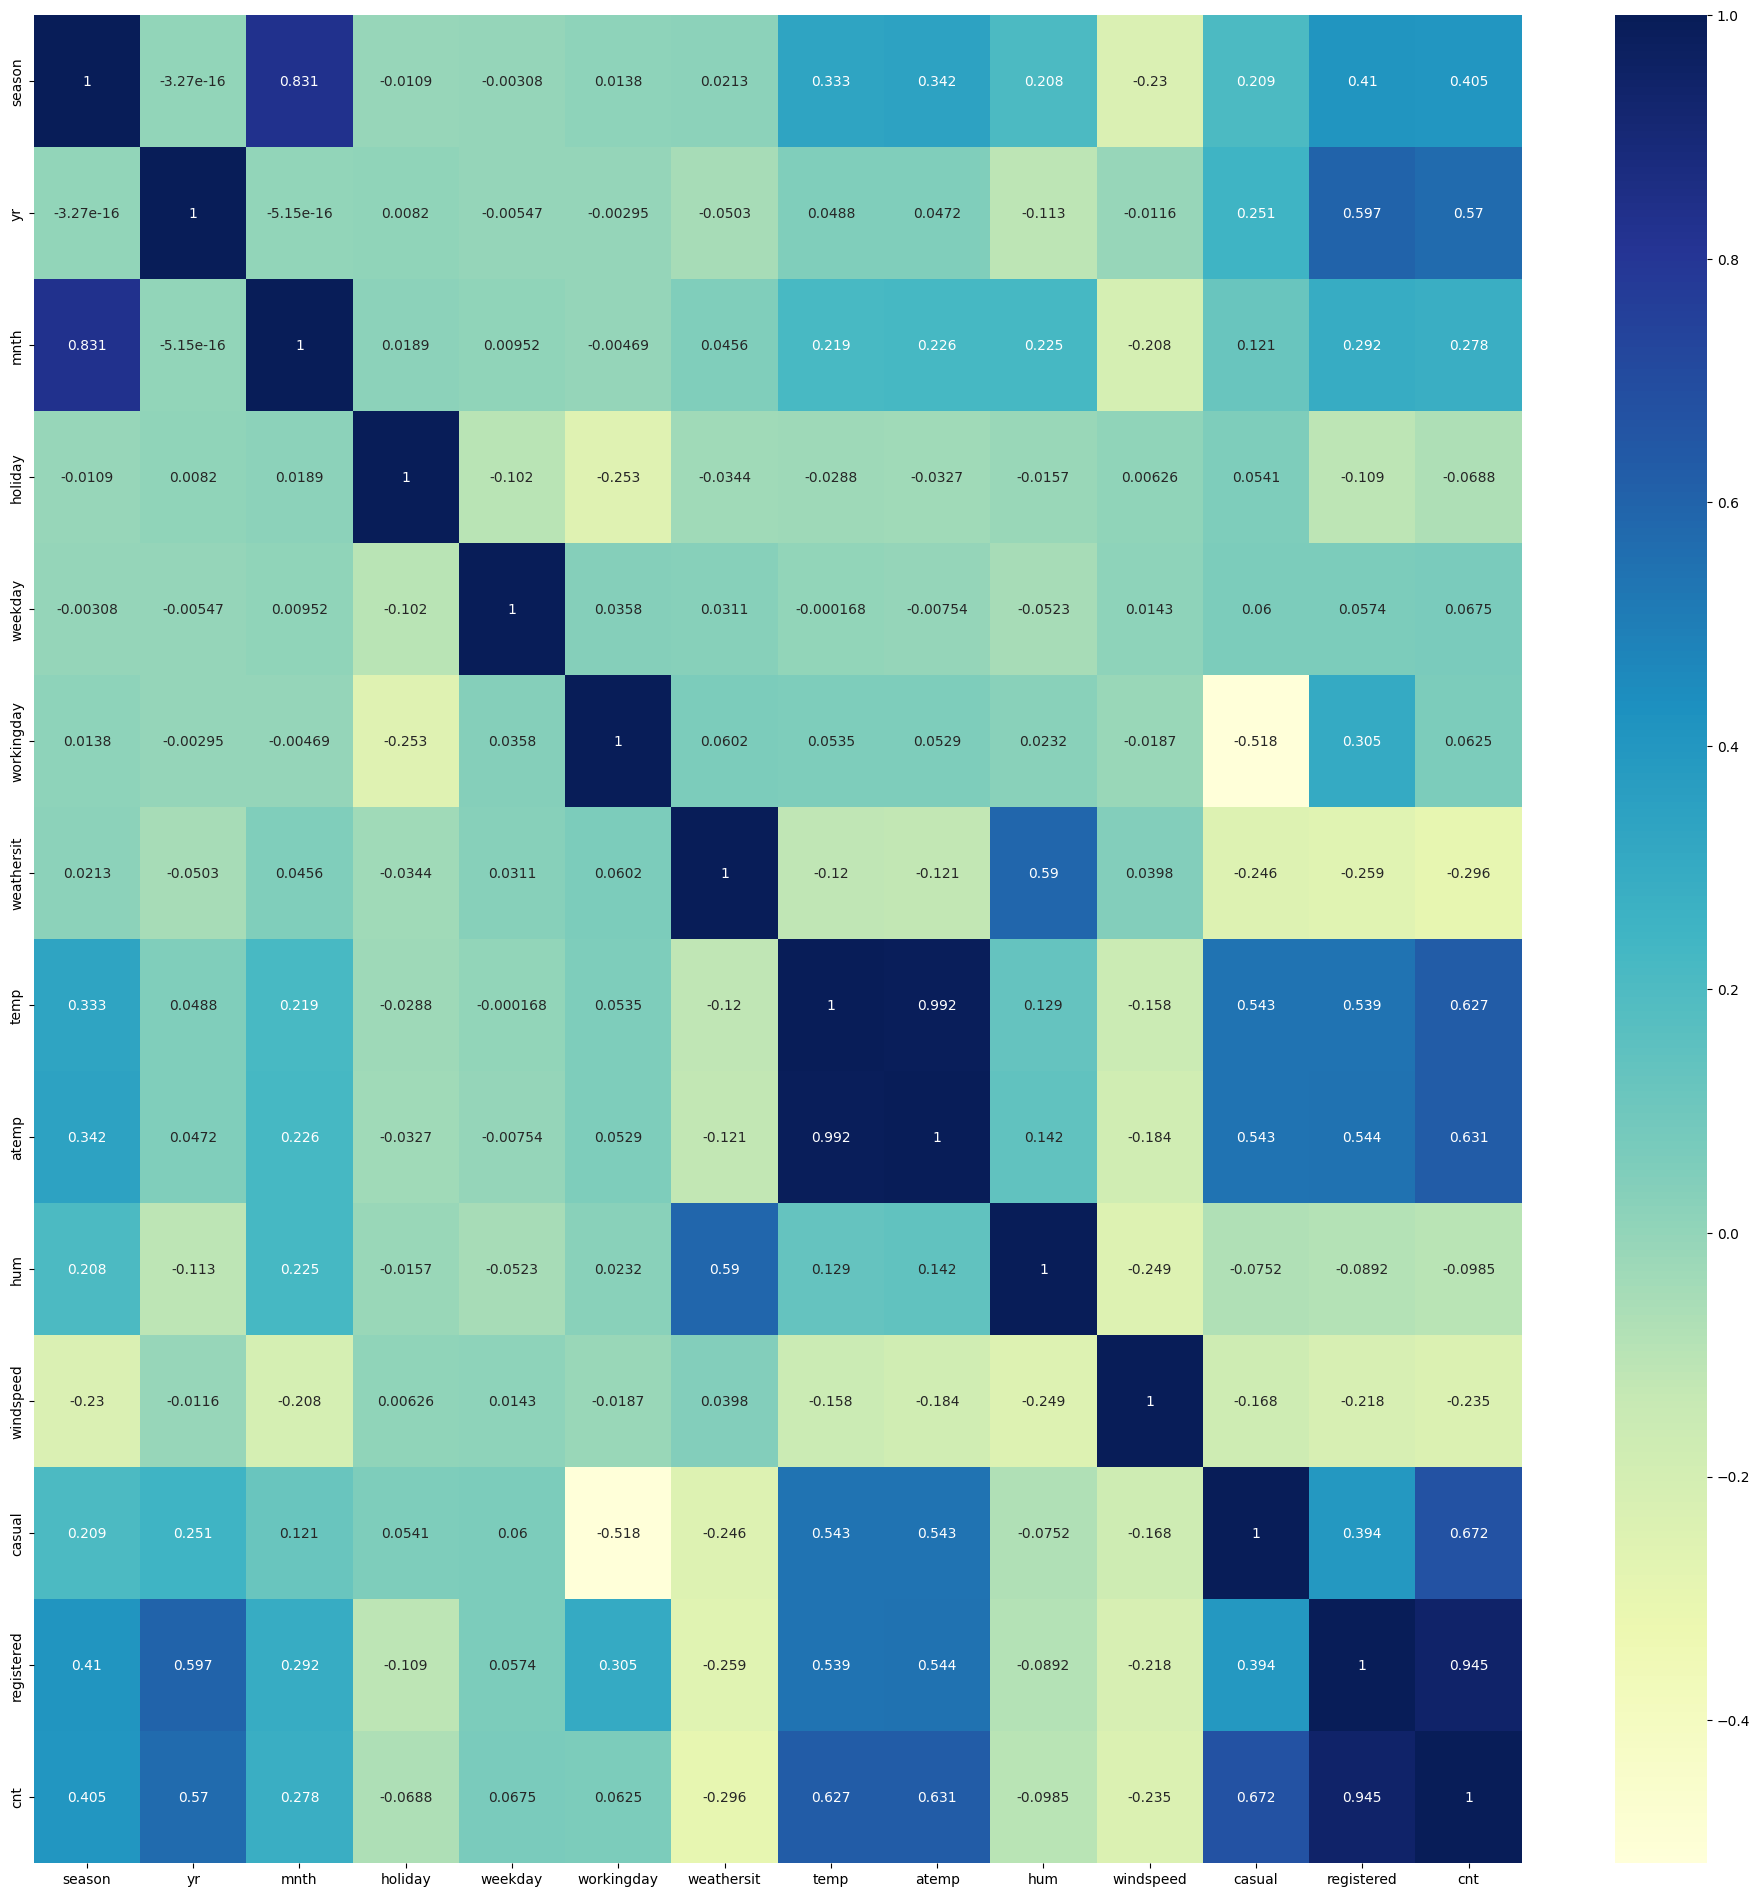

In [90]:
plt.figure(figsize = (24, 24))
sns.heatmap(bike_df.corr(), annot = True, fmt='0.3g', cmap="YlGnBu")
plt.show()

## Few observations from above heat map:
### 1) Apart from casual and registered (we'll drop them), atemp is having highest correlation coefficient with cnt followed by temp.
### 2) season is correlated with cnt. correlation coefficeint is decent. Neither too high nor too low.
### 3) yr is also corrleated with cnt. It can be a contributing factor.
### 4) mnth correlation coefficient is on low side. We need to check this statistically. It might be the case that only few months are statistically significant from model perspective.
### 5) holiday is negatively correlated with cnt. 
### 6) Similarly need to check the statistical significance for weekday, workingday, weathersit, hum and windspeed.

## Visualising Categorical Variables

### As you might have noticed, there are a few categorical variables as well. Let's make a boxplot for some of these variables.

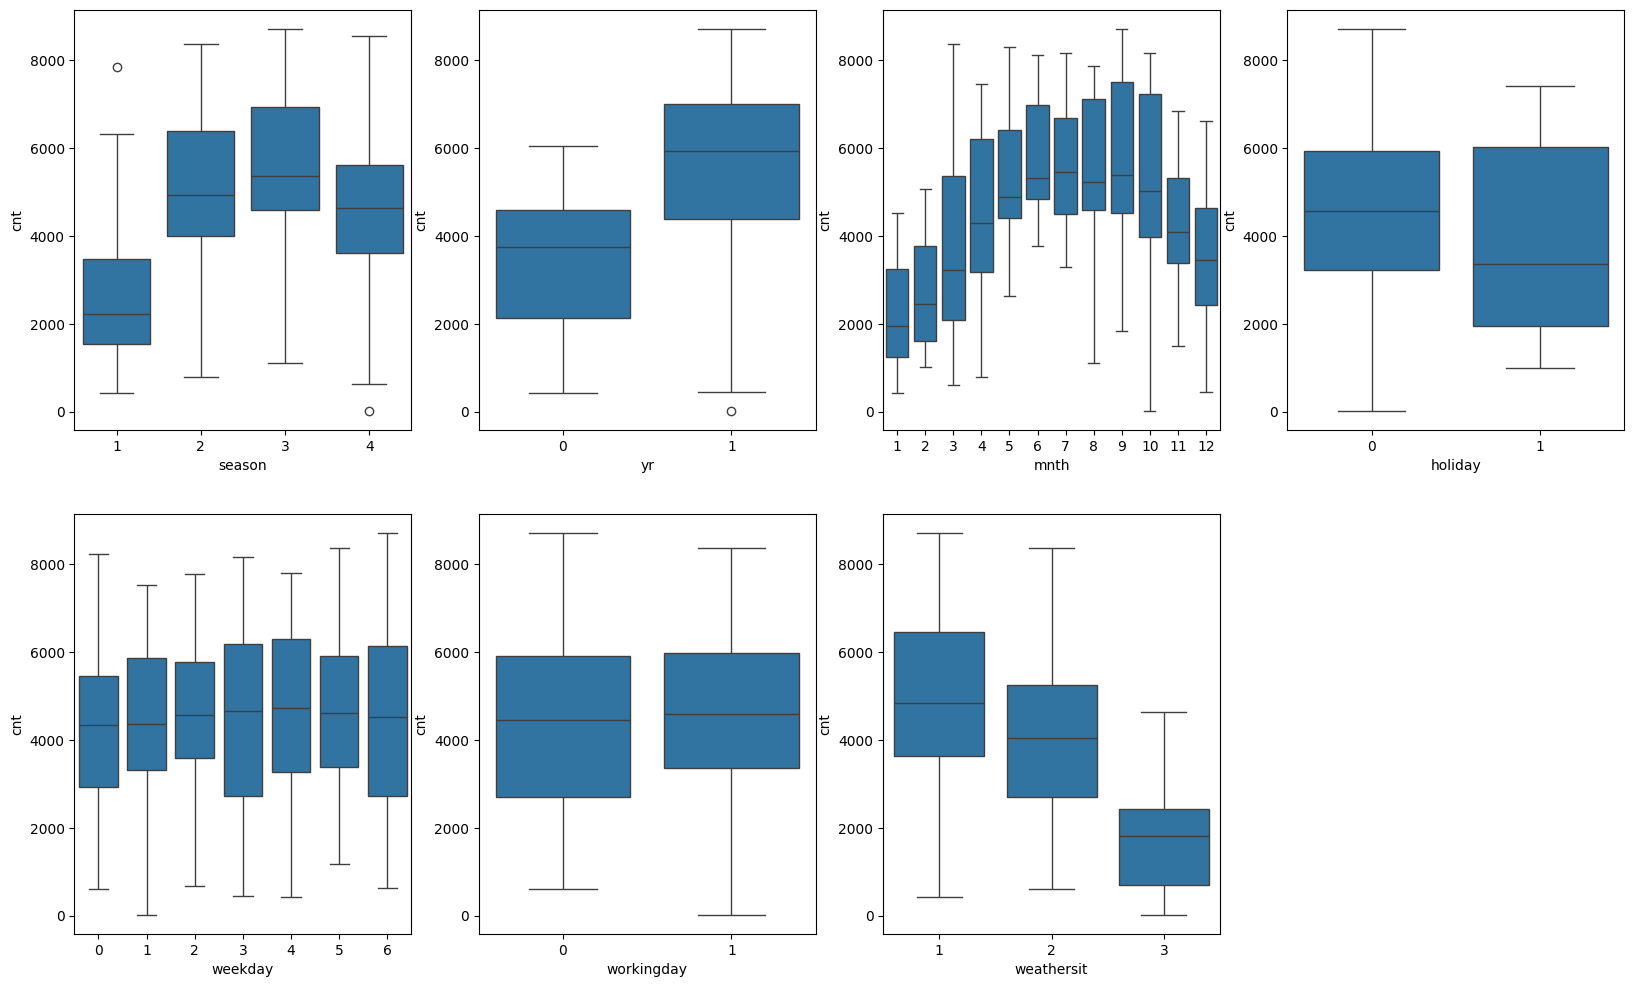

In [91]:
plt.figure(figsize=(20, 12))
plt.subplot(2,4,1)
sns.boxplot(x = 'season', y = 'cnt', data = bike_df)
plt.subplot(2,4,2)
sns.boxplot(x = 'yr', y = 'cnt', data = bike_df)
plt.subplot(2,4,3)
sns.boxplot(x = 'mnth', y = 'cnt', data = bike_df)
plt.subplot(2,4,4)
sns.boxplot(x = 'holiday', y = 'cnt', data = bike_df)
plt.subplot(2,4,5)
sns.boxplot(x = 'weekday', y = 'cnt', data = bike_df)
plt.subplot(2,4,6)
sns.boxplot(x = 'workingday', y = 'cnt', data = bike_df)
plt.subplot(2,4,7)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bike_df)
plt.show()

## Few observations from above heat map:
### 1. Median of bike rental count is highest for fall season. Need to check the statistical significance of this.
### 2. Also maximum bike rental count is for fall season.
### 3. Median of bike rental count is highest for year 2019. Also maximum bike rental count is for year 2019.
### 4. Highest bike rental count is for month 9 i.e. September.
### 5. Median of bike rental count is highest for month 7 i.e. July.
### 6. Lowest bike rental count is for month 10 i.e. October.
### 7. Median and highest bike rental count is for no holiday days marked with 0.
### 8. Bike rental median for all days are almost close to each other.
### 9. Bike rental median for working/non-working days are almost close to each other.
### 10. Bike rental median is highest for weathersit 1. Also maximum bike rental count is for weathersit 1 and lowest is for weathersit 3.

## Custom Map Functions

In [92]:
# Defining the season map function
def mapping_season_col(x):
    return x.map({1:"spring", 2:"summer", 3:"fall", 4:"winter"})

# Defining the weather map function
def mapping_weathersit_col(x):
    return x.map({1:"weathersit_1", 2:"weathersit_2", 3:"weathersit_3", 4:"weathersit_4"})

# Defining the month map function
def mapping_month_col(x):
    return x.map({1:"month_1", 
                  2:"month_2", 
                  3:"month_3", 
                  4:"month_4",
                  5:"month_5",
                  6:"month_6",
                  7:"month_7",
                  8:"month_8",
                  9:"month_9",
                  10:"month_10",
                  11:"month_11",
                  12:"month_12"})

# Defining the weekday map function
def mapping_weekday_col(x):
    return x.map({0:"Monday", 
                  1:"Tuesday", 
                  2:"Wednesday", 
                  3:"Thursday",
                  4:"Friday",
                  5:"Saturday",
                  6:"Sunday"})

# Applying the function to the season column
bike_df[["season"]] = bike_df[["season"]].apply(mapping_season_col)

# Applying the function to the weathersit column
bike_df[["weathersit"]] = bike_df[["weathersit"]].apply(mapping_weathersit_col)

# Applying the function to the month column
bike_df[["mnth"]] = bike_df[["mnth"]].apply(mapping_month_col)

# Applying the function to the weekday column
bike_df[["weekday"]] = bike_df[["weekday"]].apply(mapping_weekday_col)

## Dummy Variables Encoding

In [93]:
# Get the dummy variables for the feature 'season' and store it in a new variable - 'season_dummy_var'
season_dummy_var = pd.get_dummies(bike_df["season"], drop_first = True)

In [94]:
season_dummy_var.head()

,spring,summer,winter
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False


In [95]:
# Get the dummy variables for the feature 'weathersit' and store it in a new variable - 'weathersit_dummy_var'
weathersit_dummy_var = pd.get_dummies(bike_df["weathersit"],drop_first = True)

In [96]:
weathersit_dummy_var.head()

,weathersit_2,weathersit_3
0,True,False
1,True,False
2,False,False
3,False,False
4,False,False


In [97]:
# Get the dummy variables for the feature 'mnth' and store it in a new variable - 'mnth_dummy_var'
mnth_dummy_var = pd.get_dummies(bike_df["mnth"],drop_first = True)

In [98]:
mnth_dummy_var.head()

,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False


In [99]:
# Get the dummy variables for the feature 'weekday' and store it in a new variable - 'weekday_dummy_var'
weekday_dummy_var = pd.get_dummies(bike_df["weekday"],drop_first = True)

In [100]:
weekday_dummy_var.head()

,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,False,False,True,False,False,False
1,True,False,False,False,False,False
2,False,False,False,False,True,False
3,False,False,False,False,False,True
4,False,False,False,True,False,False


In [101]:
# Add the results to the original bike_df dataframe

bike_df = pd.concat([bike_df, season_dummy_var, weathersit_dummy_var, mnth_dummy_var, weekday_dummy_var], axis = 1)

In [102]:
bike_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,spring,summer,winter,weathersit_2,weathersit_3,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,spring,0,month_1,0,Sunday,0,weathersit_2,14.110847,18.18125,80.5833,10.749882,331,654,985,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,spring,0,month_1,0,Monday,0,weathersit_2,14.902598,17.68695,69.6087,16.652113,131,670,801,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,spring,0,month_1,0,Tuesday,1,weathersit_1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,spring,0,month_1,0,Wednesday,1,weathersit_1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,spring,0,month_1,0,Thursday,1,weathersit_1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


In [103]:
drop_these_columns_2 = ["season",
                        "weathersit",
                        "mnth",
                        "weekday",
                        "casual",
                        "registered"]
bike_df.drop(drop_these_columns_2, inplace=True, axis=1)
bike_df.shape

(730, 30)

In [104]:
bike_df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,weathersit_2,weathersit_3,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


In [105]:
bike_df.shape

(730, 30)

## Splitting the Data into Training and Testing Sets

As we know, the first basic step for regression is performing a train-test split.

In [106]:
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
bike_df_train, bike_df_test = train_test_split(bike_df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [107]:
bike_df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,weathersit_2,weathersit_3,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
653,1,0,1,19.201653,23.0423,55.8333,12.208807,7534,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
576,1,0,1,29.246653,33.1448,70.4167,11.083475,7216,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True
426,1,0,0,16.980847,20.6746,62.1250,10.792293,4066,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
728,1,0,0,10.489153,11.5850,48.3333,23.500518,1796,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False
482,1,0,0,15.443347,18.8752,48.9583,8.708325,4220,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False


In [108]:
# Apply scaler() to all the columns except the '0-1' and 'dummy' variables
scaler = MinMaxScaler()

num_vars = ["temp", "atemp", "hum", "windspeed", "cnt"]

bike_df_train[num_vars] = scaler.fit_transform(bike_df_train[num_vars])

In [109]:
bike_df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,weathersit_2,weathersit_3,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
653,1,0,1,0.509887,0.501133,0.575354,0.300794,0.864243,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False


In [110]:
bike_df_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537262,0.512989,0.650369,0.320768,0.513620
std,0.500429,0.157763,0.468282,0.225844,0.212385,0.145882,0.169797,0.224593
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420
50%,1.000000,0.000000,1.000000,0.540519,0.526811,0.653714,0.296763,0.518638
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### As we can see from above table, all values have been mapped between 0 and 1 where maximum value is 1 and minimum value is 0. This has been performed by MinMaxScaler().

### Dividing into X and Y sets for the model building

In [111]:
y_train = bike_df_train.pop('cnt')
X_train = bike_df_train ## assigning all feature variables to X_train

## Building our model

This time, we will be using the **LinearRegression function from SciKit Learn** for its compatibility with RFE (which is a utility from sklearn)

## RFE (Recursive Feature Elimination)

In [112]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(estimator=lm, n_features_to_select=18)   # my insert 

rfe = rfe.fit(X_train, y_train)

In [113]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 4),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', False, 3),
 ('winter', True, 1),
 ('weathersit_2', True, 1),
 ('weathersit_3', True, 1),
 ('month_10', False, 2),
 ('month_11', False, 7),
 ('month_12', False, 8),
 ('month_2', False, 5),
 ('month_3', True, 1),
 ('month_4', True, 1),
 ('month_5', True, 1),
 ('month_6', True, 1),
 ('month_7', False, 10),
 ('month_8', True, 1),
 ('month_9', True, 1),
 ('Monday', True, 1),
 ('Saturday', False, 6),
 ('Sunday', True, 1),
 ('Thursday', False, 12),
 ('Tuesday', False, 9),
 ('Wednesday', False, 11)]

In [114]:
# Get the selected features
selected_features = X_train.columns[rfe.support_]
# Print selected features
print("Selected features: ", selected_features)

Selected features:  Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'spring',
       'winter', 'weathersit_2', 'weathersit_3', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_8', 'month_9', 'Monday', 'Sunday'],
      dtype='object')


In [115]:
col = X_train.columns[rfe.support_] ## variables suggested by RFE
col

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'spring',
       'winter', 'weathersit_2', 'weathersit_3', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_8', 'month_9', 'Monday', 'Sunday'],
      dtype='object')

In [116]:
X_train.columns[~rfe.support_] ## rejected variables

Index(['atemp', 'summer', 'month_10', 'month_11', 'month_12', 'month_2',
       'month_7', 'Saturday', 'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')

## Building model using statsmodel, for the detailed statistics
## We are assuming significance level of 0.05.

In [117]:
# Calculate the VIFs for the new model
def calculate_VIF(col,X_train):
    vif = pd.DataFrame()
    vif['Features'] = col
    vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    display(vif)

In [118]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [119]:
X_train_rfe = X_train_rfe.apply(pd.to_numeric) 
X_train_rfe = X_train_rfe.reset_index(drop=True)

# Check for missing values
if X_train_rfe.isnull().sum().any() or y_train.isnull().sum().any():
    raise ValueError("Missing values found in the dataset")
    
y_train = y_train.reset_index(drop=True)    

In [120]:
# Adding a constant variable 
X_train_rfe = sm.add_constant(X_train_rfe)

In [121]:
print(X_train_rfe.dtypes)

const           float64
yr                int64
holiday           int64
workingday        int64
temp            float64
hum             float64
windspeed       float64
spring             bool
winter             bool
weathersit_2       bool
weathersit_3       bool
month_3            bool
month_4            bool
month_5            bool
month_6            bool
month_8            bool
month_9            bool
Monday             bool
Sunday             bool
dtype: object


In [122]:
X_train_rfe = X_train_rfe.apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(y_train, errors='coerce')

In [123]:
print(X_train_rfe.dtypes)

const           float64
yr                int64
holiday           int64
workingday        int64
temp            float64
hum             float64
windspeed       float64
spring             bool
winter             bool
weathersit_2       bool
weathersit_3       bool
month_3            bool
month_4            bool
month_5            bool
month_6            bool
month_8            bool
month_9            bool
Monday             bool
Sunday             bool
dtype: object


In [124]:
cols = X_train.columns[rfe.support_]
cols

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'spring',
       'winter', 'weathersit_2', 'weathersit_3', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_8', 'month_9', 'Monday', 'Sunday'],
      dtype='object')

In [125]:
X_train_sm = sm.add_constant(X_train_rfe[col].astype(float))
lm = sm.OLS(y_train,X_train_sm).fit()   # Running the 1st linear model

In [126]:
#Let's see the summary of our linear model
print(lm.summary())

# Function to calculate VIF (Variance Inflation Factor)
def get_vif(cols):
    X_train_sm = sm.add_constant(X_train_rfe[col].astype(float))
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X_train_sm.columns
    vif_data['VIF'] = [variance_inflation_factor(X_train_sm.values, i)
                       for i in range(X_train_sm.shape[1])]
    print(vif_data)

# Calculate VIF for the selected features
get_vif(cols)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     161.9
Date:                Wed, 19 Jun 2024   Prob (F-statistic):          6.43e-189
Time:                        14:22:36   Log-Likelihood:                 519.45
No. Observations:                 510   AIC:                            -1003.
Df Residuals:                     492   BIC:                            -926.7
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2032      0.027      7.527   

Looking at the p-values, it looks like holiday variable is not really significant (in the presence of other variables). 

Maybe we could drop it?

We could simply drop the variable with the highest, non-significant p value. A better way would be to supplement this with the VIF information. 

### Checking VIF

Variance Inflation Factor or VIF, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model. The formula for calculating `VIF` is:

### $ VIF_i = \frac{1}{1 - {R_i}^2} $

In [127]:
col

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'spring',
       'winter', 'weathersit_2', 'weathersit_3', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_8', 'month_9', 'Monday', 'Sunday'],
      dtype='object')

In [128]:
cols

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'spring',
       'winter', 'weathersit_2', 'weathersit_3', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_8', 'month_9', 'Monday', 'Sunday'],
      dtype='object')

In [131]:
#calculate_VIF(col,X_train)
calculate_VIF(X_train_sm.columns,X_train_sm)

,Features,VIF
18,Sunday,inf
2,holiday,inf
3,workingday,inf
17,Monday,inf
7,spring,4.11
4,temp,3.35
8,winter,3.18
5,hum,1.94
12,month_4,1.83
15,month_8,1.77


## We need to bring all VIFs below 5 to avoid multicollinearity issue.

## Model 2

In [132]:
X_train_new = X_train_sm[col].drop(["holiday"], axis = 1) # dropping holiday variable

In [133]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_new.astype(float))

In [134]:
lm = sm.OLS(y_train,X_train_lm).fit()
#lm_2 = sm.OLS(y_train,X_train_lm).fit()   # Running the 2nd linear model

In [135]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     161.9
Date:                Wed, 19 Jun 2024   Prob (F-statistic):          6.43e-189
Time:                        14:26:13   Log-Likelihood:                 519.45
No. Observations:                 510   AIC:                            -1003.
Df Residuals:                     492   BIC:                            -926.7
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1918      0.041      4.634   

In [136]:
calculate_VIF(X_train_new.columns,X_train_new)

,Features,VIF
3,hum,30.95
2,temp,18.34
1,workingday,18.20
4,windspeed,4.96
16,Sunday,4.85
15,Monday,4.70
5,spring,4.15
6,winter,3.58
7,weathersit_2,2.30
0,yr,2.10


## Model 3

In [137]:
X_train_new = X_train_new.drop(["hum"], axis = 1) # dropping "hum" variable

In [138]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_new)

In [139]:
lm_3 = sm.OLS(y_train,X_train_lm).fit()   # Running the 3rd linear model

In [140]:
#Let's see the summary of our linear model
print(lm_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     166.3
Date:                Wed, 19 Jun 2024   Prob (F-statistic):          8.29e-187
Time:                        14:26:57   Log-Likelihood:                 511.71
No. Observations:                 510   AIC:                            -989.4
Df Residuals:                     493   BIC:                            -917.4
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1133      0.037      3.090   

In [141]:
calculate_VIF(X_train_new.columns,X_train_new)

,Features,VIF
1,workingday,15.27
2,temp,13.40
3,windspeed,4.87
15,Sunday,4.23
14,Monday,3.98
4,spring,3.47
5,winter,2.86
0,yr,2.09
12,month_8,1.94
9,month_4,1.74


## Model 4

In [142]:
X_train_new = X_train_new.drop(["Monday"], axis = 1) # dropping "Monday" variable because its p-value is greater than 0.05

In [143]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_new)

In [144]:
lm_4 = sm.OLS(y_train,X_train_lm).fit()   # Running the 4th linear model

In [145]:
#Let's see the summary of our linear model
print(lm_4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     176.3
Date:                Wed, 19 Jun 2024   Prob (F-statistic):          3.06e-187
Time:                        14:27:45   Log-Likelihood:                 510.04
No. Observations:                 510   AIC:                            -988.1
Df Residuals:                     494   BIC:                            -920.3
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1554      0.028      5.488   

In [146]:
calculate_VIF(X_train_new.columns,X_train_new)

,Features,VIF
2,temp,7.85
3,windspeed,4.72
1,workingday,4.64
4,spring,2.35
5,winter,2.10
0,yr,2.09
12,month_8,1.92
14,Sunday,1.83
11,month_6,1.66
10,month_5,1.62


## Model 5

In [147]:
X_train_new = X_train_new.drop(["month_8"], axis = 1) ## dropping month_8

In [148]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_new)

In [149]:
lm_5 = sm.OLS(y_train,X_train_lm).fit()   # Running the 5th linear model

In [150]:
#Let's see the summary of our linear model
print(lm_5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     186.3
Date:                Wed, 19 Jun 2024   Prob (F-statistic):          6.24e-187
Time:                        14:27:56   Log-Likelihood:                 506.56
No. Observations:                 510   AIC:                            -983.1
Df Residuals:                     495   BIC:                            -919.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1650      0.028      5.843   

In [151]:
calculate_VIF(X_train_new.columns,X_train_new)

,Features,VIF
2,temp,6.15
3,windspeed,4.72
1,workingday,4.60
4,spring,2.20
0,yr,2.09
13,Sunday,1.81
5,winter,1.75
6,weathersit_2,1.56
9,month_4,1.41
11,month_6,1.35


## Model 6

In [152]:
X_train_new = X_train_new.drop(["month_6"], axis = 1) ## dropping month_6

In [153]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_new)

In [154]:
lm_6 = sm.OLS(y_train,X_train_lm).fit()   # Running the 6th linear model

In [155]:
#Let's see the summary of our linear model
print(lm_6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     198.7
Date:                Wed, 19 Jun 2024   Prob (F-statistic):          4.56e-187
Time:                        14:28:00   Log-Likelihood:                 504.13
No. Observations:                 510   AIC:                            -980.3
Df Residuals:                     496   BIC:                            -921.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1727      0.028      6.140   

In [156]:
calculate_VIF(X_train_new.columns,X_train_new)

,Features,VIF
2,temp,5.68
3,windspeed,4.69
1,workingday,4.59
4,spring,2.15
0,yr,2.09
12,Sunday,1.81
5,winter,1.65
6,weathersit_2,1.56
9,month_4,1.35
8,month_3,1.29


## Model 7

In [157]:
X_train_new = X_train_new.drop(["Sunday"], axis = 1) ## dropping Sunday

In [158]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_new)

In [159]:
lm_7 = sm.OLS(y_train,X_train_lm).fit()   # Running the 7th linear model

In [160]:
#Let's see the summary of our linear model
print(lm_7.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     205.1
Date:                Wed, 19 Jun 2024   Prob (F-statistic):          1.04e-183
Time:                        14:28:03   Log-Likelihood:                 493.37
No. Observations:                 510   AIC:                            -960.7
Df Residuals:                     497   BIC:                            -905.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2059      0.028      7.423   

In [161]:
calculate_VIF(X_train_new.columns,X_train_new)

,Features,VIF
2,temp,4.80
3,windspeed,4.64
1,workingday,3.00
0,yr,2.09
4,spring,2.03
5,winter,1.58
6,weathersit_2,1.54
9,month_4,1.34
8,month_3,1.28
10,month_5,1.26


## 1. Model 7 is our final model.
## 2. R-Squared value 0.832 and adjusted R-Squared value is 0.828.
## 3. All VIFs are now below 5. 
## 4. All p-values are below 0.05 (Rejecting the NULL hypothesis)

## Residual Analysis of the train data

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [162]:
y_train_cnt = lm_7.predict(X_train_lm)

In [163]:
## Looking at the RMSE

#Returns the mean squared error; we'll take a square root
np.sqrt(mean_squared_error(y_train, y_train_cnt))

0.09196589350029502

In [164]:
%matplotlib inline

Text(0.5, 0, 'Errors')

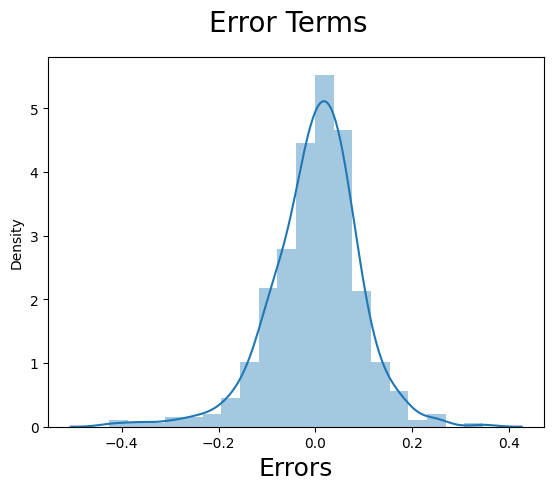

In [165]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### The residuals are following the normally distributed with a mean 0. All good!

## Looking for patterns in the residuals

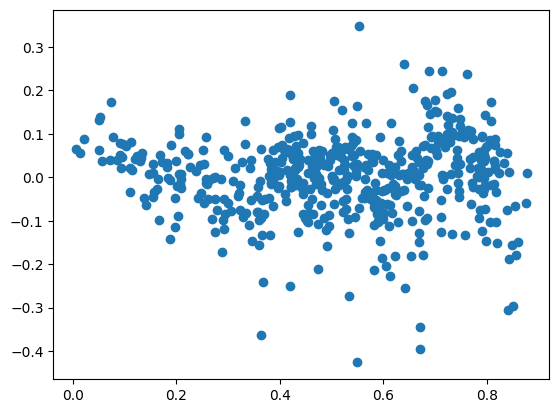

In [166]:
plt.scatter(y_train_cnt,(y_train - y_train_cnt))
plt.show()

From above plot we can see that residuals (also known as error terms) are independent. This means that there is no correlation between the residuals and the predicted values, or among the residuals themselves.

### We are confident that the model fit isn't by chance, and has decent predictive power. The normality of residual terms allows some inference on the coefficients.

## Making Predictions

#### Applying the scaling on the test sets

In [167]:
# Apply scaler() to all the columns except the '0-1' and 'dummy' variables
num_vars = ["temp", "atemp", "hum", "windspeed", "cnt"]

bike_df_test[num_vars] = scaler.transform(bike_df_test[num_vars])

In [168]:
bike_df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,weathersit_2,weathersit_3,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0.692706,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0.712034,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0.303382,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0.547400,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False
152,0,0,1,0.817246,0.741471,0.314298,0.537414,0.569029,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


#### Dividing into X_test and y_test

In [169]:
y_test = bike_df_test.pop('cnt')
X_test = bike_df_test

In [170]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [171]:
# Making predictions
y_pred = lm_7.predict(X_test_new)

## Model Evaluation

Text(0, 0.5, 'y_pred')

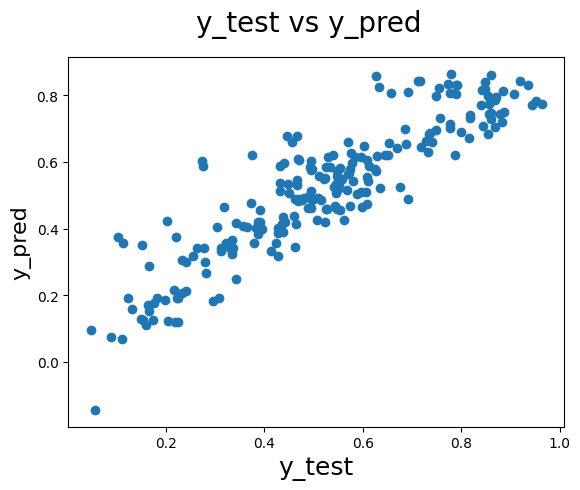

In [172]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

## Looking at the RMSE

In [173]:
#Returns the mean squared error; we'll take a square root
np.sqrt(mean_squared_error(y_test, y_pred))

0.09576593186119745

In [174]:
R2 = r2_score(y_test, y_pred)
R2

0.8069068816299572

In [175]:
adj_R2 = 1-(1-R2)*(219-1)/(219-12-1)
adj_R2

0.7956587388122848

## So final r2_score (R-Squared) for test set is 0.8069068816299572.
## And Adjusted R-Squared value for test set is 0.7956587388122848

In [176]:
print(lm_7.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     205.1
Date:                Wed, 19 Jun 2024   Prob (F-statistic):          1.04e-183
Time:                        14:30:03   Log-Likelihood:                 493.37
No. Observations:                 510   AIC:                            -960.7
Df Residuals:                     497   BIC:                            -905.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2059      0.028      7.423   


We can see that the equation of our best fitted line is:

$ cnt = 0.205947 + 0.234120 \times  yr + 0.021870  \times  workingday + 0.449452 \times temp - 0.148696 \times windspeed - 0.092775 \times spring + 0.077122 \times winter - 0.079888 \times weathersit_2 - 0.287815 \times weathersit_3 + 0.051687 \times month_3 + 0.042965 \times month_4 + 0.054176 \times month_5 + 0.079989 \times month_9 $


In [177]:
summary_df = pd.DataFrame({"Model Performance Metrics":["R-Squared Value","Adjusted R-Squared Value","RMSE"],
                         "Train Set":[0.832,0.828,0.09196],
                         "Test Set":[0.8069,0.7956,0.09576]})

# Conclusion

In [178]:
summary_df

,Model Performance Metrics,Train Set,Test Set
0,R-Squared Value,0.83200,0.80690
1,Adjusted R-Squared Value,0.82800,0.79560
2,RMSE,0.09196,0.09576
